In [27]:
%run import_getters.ipynb    
%run import_plots.ipynb
%run import_dbase.ipynb


In [28]:
def timeTableQuery (dataBase, run, tableName, startTime, endTime):
    ''' NAME
        timeQuery 

    FILE
        import_getters.ipynb

    DESCRIPTION

        This function establishes a MySQL connection between the python notebook and the server to fetch data
        for a specified time frame.  The function creates and outputs 5 dataframes out of the raw data fetched.
        - Log 
        - PLC
        - FlowIn
        - FlowOut
        - Voltage

        If the connection to the MySQL database cannot be established it throws an exception.     

    INPUT
        dataBase:  string name of database
        run:       string name of run 
        startTime: time in string format (YYYY-MM-DD 00:00:00.000000)
        endTime:   time in string format (YYYY-MM-DD 00:00:00.000000)

    RETURN
        5 panda dataframes 

    EXAMPLE
    
        dataBase  = 'rct007'
        run       = '004'
        startTime = '2016-06-28 00:46:39.381692'
        endTime   = '2016-06-28 01:16:41.334500'
        
        [plcDf, logDf, flowInDf, flowOutDf, voltageDf] = timeQuery(dataBase, run, startTime, endTime)'''
    
    # Establish a MySQL connection with the server, throw an exeption if the connection cannot be established. 
    
    try:
        cursor = connectDbase(dataBase)
    except:
        sys.exit('Connection to MySQL database cannot be established')
    
    # Define table names for query
#     tbName0 = run + '_plcdata'
#     tbName1 = run+ '_logdata'
#     tbName2 = run + '_flowindata'
#     tbName3 = run + '_flowoutdata'
#     tbName4 = run + '_voltagedata'

    # Fetch data from server
    df     = readDateTable(cursor, tableName, startTime, endTime)
#    log     = readDateTable(cursor,tbName1, startTime, endTime)
#     flowIn  = readDateTable(cursor,tbName2, startTime, endTime)
#     flowOut = readDateTable(cursor,tbName3, startTime, endTime)
#    voltage = readDateTable(cursor,tbName4, startTime, endTime)
    
    return df

In [6]:
end = datetime.datetime.utcnow()
start = end - datetime.timedelta(hours=24)
end = str(pd.to_datetime(end))
start = str(pd.to_datetime(start))

In [ ]:
start = '2016-09-06 14:00:00'
end =  '2016-09-06 16:00:00'

In [30]:
t = timeTableQuery('rct008', '002', '002_plcdata', start, end)
v = timeTableQuery('rct007b', '004', '004_voltagedata', start, '2016-09-06 14:50:00')

In [35]:
v = timeTableQuery('rct007b', '004', '004_voltagedata', '2016-09-06 15:36:00', '2016-09-06 15:37:00')

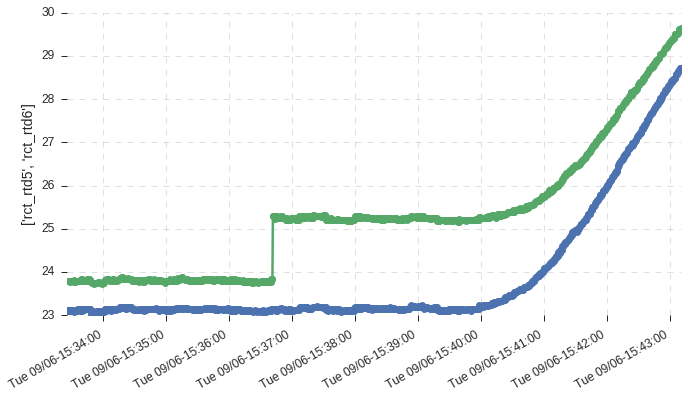

In [31]:
iSlidePlot(t)

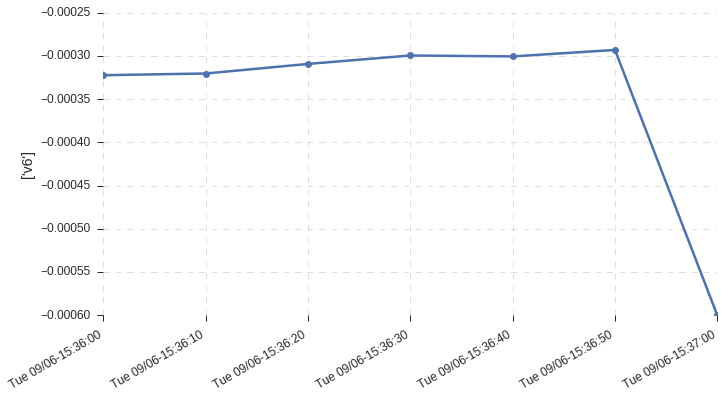

In [36]:
iSlidePlot(v)

In [ ]:
A = getEngData('rct_rtd1', (1, 'rct007', '004'))
B = getEngData('rct_rtd2', (1, 'rct007', '004'))

In [ ]:
pplot(A[1]);

In [ ]:
def pscatter(df, col1='none', col2='none'):
    sns.set_style("white")
    sns.set_style("ticks")
    fig, ax = plt.subplots(figsize=(11, 6))
    
    if isinstance(df, pd.DataFrame):
        c1=df[col1].values
        c2=df[col2].values
        plt.scatter(c1, c2)
        plt.ylabel(col2, fontsize=14)
        plt.xlabel(col1, fontsize=14)
    else:
        plt.scatter(df,col1)
    
    plt.tick_params(axis='y', labelsize=12)
    plt.tick_params(which='major', axis='x', labelsize=12)
    plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    sns.despine(trim=True, left=True, bottom=True)
    return fig


In [ ]:
a = A[1]
b = B[1]
pscatter(a,b);

In [ ]:
C = pd.DataFrame(index=A[0], data=np.concatenate((A[1],B[1]), axis=1), columns=['a', 'b'])

In [ ]:
pscatter(C, 'a', 'b');

In [ ]:
C['a'].values

In [ ]:
A = timeQuery('rct007', '004', '2016-07-12 22:03:00', '2016-07-12 22:04:00')

In [ ]:
v = A[4]
iSlidePlot(v)

In [24]:
def slidePlot(dfIn, signal=('atc1_mean',), resample_rate_in_sec=RESAMP_INIT, 
              start=0, end=MAX_DF_LEN, resampMethod='rms'):
    
    sns.set_style("white")
    sns.set_style("ticks")

    dfIn = dfIn.ix[start:end,:]
    col = list(signal)
    title = signal
    dt = str(resample_rate_in_sec) + 's'
    
    # get x,y (rng, out) for plot
    if resampMethod == 'rms':
        out = dfIn[col].resample(dt).apply(rms)
    elif resampMethod == 'mean':
        out = dfIn[col].resample(dt).apply(np.mean)
    else:
        out = dfIn[col]
        
    #print out
    #print dfIn[col].resample(dt)
    
    rng = pd.to_datetime(out.index)

    fig, ax = plt.subplots(figsize=(11, 6))
    plt.plot(rng, out, 'v-', lw=2.5, marker='o')

    
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(dates.DateFormatter('%a %m/%d-%H:%M:%S'))
    plt.ylabel(col, fontsize=14)
    plt.tick_params(axis='y', labelsize=12)
    plt.tick_params(which='major', axis='x', labelsize=12)
    plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    sns.despine(trim=True, left=True, bottom=True)    
    
    return 

def iSlidePlot(df, MAX_RESAMP_TIME=RESAMP_MAX, DELTA_SAMP=DELTA_SAMP_MIN, DELTA_TIME=1):
    
    if df.empty:
        print 'Null DataFrame'
    else:

        %matplotlib inline
    
        attributes = df.columns.tolist()
        MAX_NUM = len(df)-2

        sigWid = widgets.SelectMultiple(
        description = "Signal",
        options=df.columns.tolist(),
        )

        resampMethodWid = widgets.RadioButtons(
        description='Resample Method',
        options=['mean', 'rms', 'none'],
        value='mean',
        )

        resampRateWid = widgets.IntSlider(
        min=DELTA_SAMP,
        max=MAX_RESAMP_TIME,
        step=DELTA_SAMP,
        value=MAX_RESAMP_TIME,
        description='Resample Rate (s)', 
        continuous_update=False,
        )

        startWid = widgets.IntSlider(
        value=0,
        min=0,
        max=len(df),
        step=DELTA_TIME,
        description='Start Sample', 
        continuous_update=False,
        )

        endWid = widgets.IntSlider(
        value=len(df),
        min=0,
        max=len(df),
        step=DELTA_TIME,
        description='End Sample', 
        continuous_update=False,
        )
    
        interact(slidePlot, dfIn=fixed(df), 
             signal=sigWid, 
             resample_rate_in_sec=resampRateWid, 
             start=startWid, 
             end=endWid,
             resampMethod = resampMethodWid)
    return
